In [1]:
import numpy as np
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
#https://iwatobipen.wordpress.com/2017/01/22/encode-and-decode-smiles-strings/

SMILES_CHARS = [' ',
                  '#', '%', '(', ')', '+', '-', '.', '/',
                  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  '=', '@',
                  'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                  'R', 'S', 'T', 'V', 'X', 'Z',
                  '[', '\\', ']',
                  'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                  't', 'u',':','d','G','h','W','U','D','y','Y']
smi2index = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
index2smi = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )
def smiles_encoder( smiles, maxlen=1000 ):
    smiles =smiles
    X = np.zeros( ( maxlen, len( SMILES_CHARS ) ) )
    for i, c in enumerate( smiles ):
        X[i, smi2index[c] ] = 1
    return X
 
def smiles_decoder( X ):
    smi = ''
    X = X.argmax( axis=-1 )
    for i in X:
        smi += index2smi[ i ]
    return smi

In [3]:
#!git clone https://github.com/topazape/LSTM_Chem



text_file = open("LSTM_Chem/datasets/dataset_cleansed.smi", "r")
lines = text_file.read().splitlines()
smiles2=lines

In [12]:
#Taking only 10000 molecules
import numpy as np
X=[smiles_encoder(i) for i in smiles2[0:10000]]

In [13]:
X=np.array(X)

In [14]:
import keras, keras.layers as L, keras.backend as K

In [26]:
def build_deep_autoencoder(seq_shape, code_size):

    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(seq_shape))
    
    encoder.add(L.LSTM(100, return_sequences='True'))
    encoder.add(L.TimeDistributed(L.Dense(100)))
    encoder.add(L.Dropout(0.5))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dropout(0.5))
    decoder.add(L.Dense(1000*65))
    decoder.add(L.Reshape((1000, 65)))
    decoder.add(L.LSTM(65, return_sequences='True'))
    return encoder, decoder

In [27]:
seq_shape=X[0].shape
code_size=2
encoder, decoder = build_deep_autoencoder(seq_shape, code_size=2)
encoder.summary()
decoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1000, 100)         66400     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1000, 100)         10100     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1000, 100)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 200002    
Total params: 276,502
Trainable params: 276,502
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
Layer (type)            

In [28]:
encoder, decoder = build_deep_autoencoder(seq_shape, code_size=2)

inp = L.Input(seq_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [29]:
#Fitting for 10 iterations. This hyperparameter can be fine-tuned.
autoencoder.fit(x=X, y=X, epochs=10,verbose=1)

Epoch 1/10
10000/10000 [==============================] - 571s 57ms/step - loss: 7.0004e-04
Epoch 2/10
10000/10000 [==============================] - 572s 57ms/step - loss: 6.8668e-04
Epoch 3/10
10000/10000 [==============================] - 572s 57ms/step - loss: 6.8594e-04
Epoch 4/10
10000/10000 [==============================] - 573s 57ms/step - loss: 6.8530e-04
Epoch 5/10
10000/10000 [==============================] - 573s 57ms/step - loss: 6.8455e-04
Epoch 6/10
10000/10000 [==============================] - 571s 57ms/step - loss: 6.8391e-04
Epoch 7/10
10000/10000 [==============================] - 570s 57ms/step - loss: 6.8336e-04
Epoch 8/10
10000/10000 [==============================] - 572s 57ms/step - loss: 6.8279e-04
Epoch 9/10
10000/10000 [==============================] - 572s 57ms/step - loss: 6.8251e-04
Epoch 10/10
10000/10000 [==============================] - 573s 57ms/step - loss: 6.8189e-04


In [30]:
encoded=encoder.predict(X)

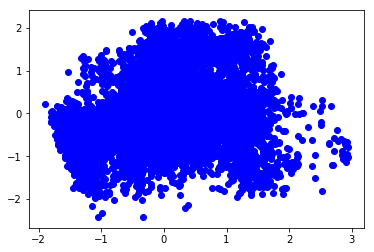

In [31]:
import matplotlib.pyplot as plt
plt.scatter(encoded.T[0], encoded.T[1], color='b')
plt.show()

In [43]:
#MSE on the training set
autoencoder.evaluate(X,X)

10000/10000 [==============================] - 192s 19ms/step


0.0006730647327378392